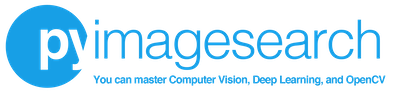

# Contrastive Loss for Siamese Networks with Keras and TensorFlow

### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Contrastive Loss for Siamese Networks with Keras and TensorFlow](https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/) blog post published on 01-18-21.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook.

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible joining PyImageSearch Plus at [http://pyimg.co/plus/](http://pyimg.co/plus) today.*

### Download the code zip file

In [1]:
#!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/contrastive-loss-keras/contrastive-loss-keras.zip
#!unzip -qq contrastive-loss-keras.zip
#%cd contrastive-loss-keras

## Blog Post Code

### Import Packages

In [2]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from imutils.paths import list_images
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

### Our `Config` class

In [11]:
class config:
    # specify the shape of the inputs for our network
    IMG_SHAPE = (28, 28, 1)

    # specify the batch size and number of epochs
    BATCH_SIZE = 64

    # Usually, we need 100s of epochs
    # with Siamese Networks
    EPOCHS = 5 #100

    # define the path to the base output directory
    BASE_OUTPUT = "output"

    # use the base output path to derive the path to the serialized
    # model along with training history plot
    MODEL_PATH = os.path.sep.join([BASE_OUTPUT,
        "contrastive_siamese_model"])
    PLOT_PATH = os.path.sep.join([BASE_OUTPUT,
        "contrastive_plot.png"])

### Creating our helper utility functions

In [4]:
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []

	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
	idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]

		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]

		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])

		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]

		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])

	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [5]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors

	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [6]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

### Implementing our siamese network architecture

In [7]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)

	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)

	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)

	# build the model
	model = Model(inputs, outputs)

	# return the model to the calling function
	return model

### Implementing contrastive loss with Keras and TensorFlow

In [8]:
def contrastive_loss(y, preds, margin=1):
	# explicitly cast the true class label data type to the predicted
	# class label data type (otherwise we run the risk of having two
	# separate data types, causing TensorFlow to error out)
	y = tf.cast(y, preds.dtype)

	# calculate the contrastive loss between the true labels and
	# the predicted labels
	squaredPreds = K.square(preds)
	squaredMargin = K.square(K.maximum(margin - preds, 0))
	loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

	# return the computed contrastive loss to the calling function
	return loss

### Creating our contrastive loss training script

In [9]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

[INFO] loading MNIST dataset...
[INFO] preparing positive and negative pairs...


In [10]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=config.IMG_SHAPE)
imgB = Input(shape=config.IMG_SHAPE)
featureExtractor = build_siamese_model(config.IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

[INFO] building siamese network...


In [ ]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam")

# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=config.BATCH_SIZE,
	epochs=config.EPOCHS)

# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(config.MODEL_PATH)

# plot the training history
print("[INFO] plotting training history...")
plot_training(history, config.PLOT_PATH)

### Implementing our contrastive loss test script


In [12]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="path to input directory of testing images")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "examples"
}

In [13]:
# grab the test dataset image paths and then randomly generate a
# total of 10 image pairs
print("[INFO] loading test dataset...")
testImagePaths = list(list_images(args["input"]))
np.random.seed(42)
pairs = np.random.choice(testImagePaths, size=(10, 2))

# load the model from disk
print("[INFO] loading siamese model...")
model = load_model(config.MODEL_PATH, compile=False)

[INFO] loading test dataset...
[INFO] loading siamese model...


C:\Users\Msagardi\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\lambda_layer.py:325: UserWarning: pyimagesearch.utils is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


1/1 [==============================] - 0s 189ms/step


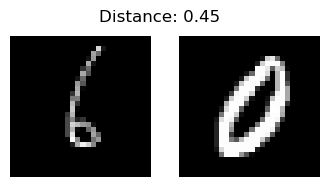

1/1 [==============================] - 0s 33ms/step


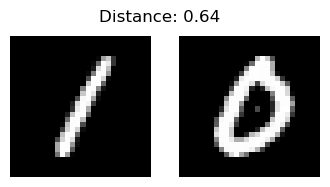

1/1 [==============================] - 0s 24ms/step


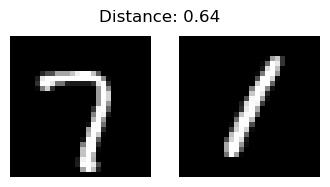

1/1 [==============================] - 0s 31ms/step


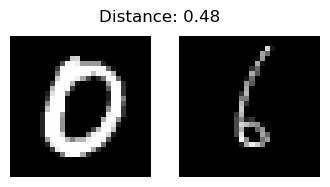

1/1 [==============================] - 0s 23ms/step


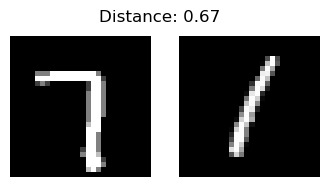

1/1 [==============================] - 0s 27ms/step


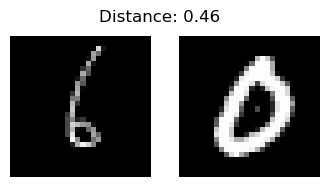

1/1 [==============================] - 0s 22ms/step


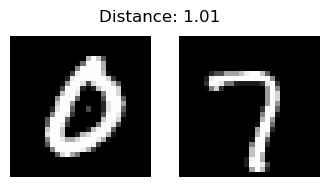

1/1 [==============================] - 0s 29ms/step


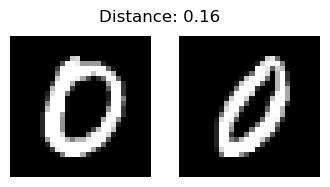

1/1 [==============================] - 0s 31ms/step


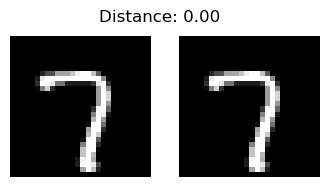

1/1 [==============================] - 0s 23ms/step


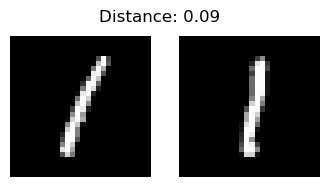

In [14]:
# loop over all image pairs
for (i, (pathA, pathB)) in enumerate(pairs):
	# load both the images and convert them to grayscale
	imageA = cv2.imread(pathA, 0)
	imageB = cv2.imread(pathB, 0)

	# create a copy of both the images for visualization purpose
	origA = imageA.copy()
	origB = imageB.copy()

	# add channel a dimension to both the images
	imageA = np.expand_dims(imageA, axis=-1)
	imageB = np.expand_dims(imageB, axis=-1)

	# add a batch dimension to both images
	imageA = np.expand_dims(imageA, axis=0)
	imageB = np.expand_dims(imageB, axis=0)

	# scale the pixel values to the range of [0, 1]
	imageA = imageA / 255.0
	imageB = imageB / 255.0

	# use our siamese model to make predictions on the image pair,
	# indicating whether or not the images belong to the same class
	preds = model.predict([imageA, imageB])
	proba = preds[0][0]

	# initialize the figure
	fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
	plt.suptitle("Distance: {:.2f}".format(proba))

	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(origA, cmap=plt.cm.gray)
	plt.axis("off")

	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(origB, cmap=plt.cm.gray)
	plt.axis("off")

	# show the plot
	plt.show()

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Contrastive Loss for Siamese Networks with Keras and TensorFlow*](https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/) blog post published on 01-18-21.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```